# 04 - Modelo con LightGBM

Este notebook implementa un modelo de **LightGBM** (Gradient Boosting) para predecir el rendimiento de estudiantes en las Pruebas Saber Pro.

**Estrategia:**
- Preprocesamiento: igual al notebook 02 y 03
- Modelo: LightGBM (más eficiente en memoria que Random Forest)
- Validación: Accuracy con early stopping
- Output: submission_lgbm.csv para Kaggle

**Ventajas de LightGBM sobre Random Forest:**
- Menor consumo de RAM (ideal para Colab)
- Más rápido de entrenar
- Generalmente mejor accuracy
- Maneja bien categorías sin One-Hot Encoding

## 1. Instalar e importar librerías

In [ ]:
# Instalar LightGBM
!pip install lightgbm -q
print("LightGBM instalado")

✓ LightGBM instalado


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print(f"Librerías importadas correctamente")
print(f"LightGBM version: {lgb.__version__}")

✓ Librerías importadas correctamente
LightGBM version: 4.6.0


## 2. Cargar datos

In [ ]:
# Cargar train y test
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nClases en train: {df_train['RENDIMIENTO_GLOBAL'].value_counts()}")

Train shape: (692500, 21)
Test shape: (296786, 20)

Clases en train: RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


## 3. Preprocesamiento

Aplicamos preprocesamiento similar al notebook 02/03.

**Diferencia clave con Random Forest:**
- LightGBM maneja categorías nativamente, así que usamos Label Encoding en lugar de One-Hot
- Esto reduce significativamente el número de columnas y el uso de memoria

In [ ]:
def preprocess_data_lgbm(df, is_train=True):
    """
    Preprocesamiento optimizado para LightGBM.
    Usa Label Encoding para todas las categóricas.

    Args:
        df: DataFrame a procesar
        is_train: True si es train (tiene RENDIMIENTO_GLOBAL)

    Returns:
        DataFrame procesado
    """
    df_copy = df.copy()

    # Guardar ID y target (si existe)
    ids = df_copy['ID'].copy()
    if is_train:
        target = df_copy['RENDIMIENTO_GLOBAL'].copy()

    # Eliminar columnas no necesarias
    cols_to_drop = ['ID']
    if is_train:
        cols_to_drop.append('RENDIMIENTO_GLOBAL')
    df_copy = df_copy.drop(cols_to_drop, axis=1)

    # 1. Procesar E_VALORMATRICULAUNIVERSIDAD (ordinal)
    valor_orden = {
        'Menos de 500 mil': 0,
        'Entre 500 mil y menos de 1 millón': 1,
        'Entre 1 millón y menos de 2.5 millones': 2,
        'Entre 2.5 millones y menos de 4 millones': 3,
        'Entre 4 millones y menos de 5.5 millones': 4,
        'Entre 5.5 millones y menos de 7 millones': 5,
        'Más de 7 millones': 6
    }
    df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].map(valor_orden)

    # 2. Procesar E_HORASSEMANATRABAJA (ordinal)
    horas_orden = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    }
    df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].map(horas_orden)

    # 3. Procesar F_ESTRATOVIVIENDA (ordinal)
    estrato_map = {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
    df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].map(estrato_map)

    # 4. Procesar variables de educación de padres (ordinal)
    educacion_orden = {
        'Ninguno': 0,
        'Primaria incompleta': 1,
        'Primaria completa': 2,
        'Secundaria (Bachillerato) incompleta': 3,
        'Secundaria (Bachillerato) completa': 4,
        'Técnica o tecnológica incompleta': 5,
        'Técnica o tecnológica completa': 6,
        'Educación profesional incompleta': 7,
        'Educación profesional completa': 8,
        'Postgrado': 9,
        'No sabe': 2
    }
    df_copy['F_EDUCACIONPADRE'] = df_copy['F_EDUCACIONPADRE'].map(educacion_orden)
    df_copy['F_EDUCACIONMADRE'] = df_copy['F_EDUCACIONMADRE'].map(educacion_orden)

    # 5. Procesar variables binarias (Si/No)
    binary_map = {'Si': 1, 'No': 0, 'S': 1, 'N': 0}
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL',
                   'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'E_PAGOMATRICULAPROPIO']

    for col in binary_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].map(binary_map)

    # Mapear E_PRIVADO_LIBERTAD
    df_copy['E_PRIVADO_LIBERTAD'] = df_copy['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0})

    # 6. Label Encoding para E_PRGM_ACADEMICO (LightGBM maneja esto bien)
    le_programa = LabelEncoder()
    df_copy['E_PRGM_ACADEMICO'] = le_programa.fit_transform(df_copy['E_PRGM_ACADEMICO'].astype(str))

    # 7. Label Encoding para E_PRGM_DEPARTAMENTO (en lugar de One-Hot)
    le_depto = LabelEncoder()
    df_copy['E_PRGM_DEPARTAMENTO'] = le_depto.fit_transform(df_copy['E_PRGM_DEPARTAMENTO'].astype(str))

    # 8. Imputar valores faltantes
    # Para numéricas: mediana
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())

    # Para categóricas: moda
    object_cols = df_copy.select_dtypes(include=['object']).columns
    for col in object_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])

    # Agregar ID de vuelta
    df_copy.insert(0, 'ID', ids)

    # Agregar target si es train
    if is_train:
        df_copy['RENDIMIENTO_GLOBAL'] = target

    return df_copy

print("✓ Funciones de preprocesamiento definidas")

✓ Funciones de preprocesamiento definidas


In [ ]:
# Aplicar preprocesamiento
print("Preprocesando train...")
df_train_processed = preprocess_data_lgbm(df_train, is_train=True)

print("Preprocesando test...")
df_test_processed = preprocess_data_lgbm(df_test, is_train=False)

print(f"\n✓ Preprocesamiento completo")
print(f"Train procesado: {df_train_processed.shape}")
print(f"Test procesado: {df_test_processed.shape}")
print(f"\nNOTA: Menos columnas que en RF debido a Label Encoding en lugar de One-Hot")
print(f"Valores faltantes en train: {df_train_processed.isna().sum().sum()}")
print(f"Valores faltantes en test: {df_test_processed.isna().sum().sum()}")

Preprocesando train...
Preprocesando test...

✓ Preprocesamiento completo
Train procesado: (692500, 21)
Test procesado: (296786, 20)

NOTA: Menos columnas que en RF debido a Label Encoding en lugar de One-Hot
Valores faltantes en train: 0
Valores faltantes en test: 0


## 4. Preparar datos para entrenamiento

In [ ]:
# Separar features y target
X = df_train_processed.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y = df_train_processed['RENDIMIENTO_GLOBAL']

# LightGBM requiere labels numéricos para clasificación
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Guardar mapeo de clases
class_mapping = dict(zip(le_target.transform(le_target.classes_), le_target.classes_))
print("Mapeo de clases:")
for k, v in class_mapping.items():
    print(f"  {k} -> {v}")

# Guardar IDs de test para la submission
test_ids = df_test_processed['ID'].copy()
X_test = df_test_processed.drop(['ID'], axis=1)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nX_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Mapeo de clases:
  0 -> alto
  1 -> bajo
  2 -> medio-alto
  3 -> medio-bajo

X_train: (554000, 19)
X_val: (138500, 19)
X_test: (296786, 19)


## 5. Entrenar LightGBM Baseline

Primero entrenamos un modelo básico con parámetros por defecto.

In [ ]:
# Crear datasets de LightGBM (formato optimizado)
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Parámetros baseline
params_baseline = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'verbose': -1,
    'seed': 42
}

print("Entrenando LightGBM baseline...")
print("NOTA: LightGBM usa early stopping automático para evitar overfitting\n")

# Entrenar con early stopping
model_baseline = lgb.train(
    params_baseline,
    train_data,
    num_boost_round=200,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)]
)

# Predicciones
y_train_pred_proba = model_baseline.predict(X_train)
y_val_pred_proba = model_baseline.predict(X_val)

y_train_pred = np.argmax(y_train_pred_proba, axis=1)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Evaluación
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n{'='*50}")
print(f"RESULTADOS BASELINE")
print(f"{'='*50}")
print(f"Accuracy en train: {train_acc:.4f}")
print(f"Accuracy en val: {val_acc:.4f}")
print(f"Número de árboles usados: {model_baseline.best_iteration}")

# Convertir predicciones a labels originales para el reporte
y_val_pred_labels = le_target.inverse_transform(y_val_pred)
y_val_labels = le_target.inverse_transform(y_val)

print(f"\nReporte de clasificación (validación):")
print(classification_report(y_val_labels, y_val_pred_labels))

Entrenando LightGBM baseline...
NOTA: LightGBM usa early stopping automático para evitar overfitting

Training until validation scores don't improve for 20 rounds
[20]	train's multi_logloss: 1.25276	valid's multi_logloss: 1.25509
[40]	train's multi_logloss: 1.22762	valid's multi_logloss: 1.23123
[60]	train's multi_logloss: 1.21529	valid's multi_logloss: 1.22004
[80]	train's multi_logloss: 1.20827	valid's multi_logloss: 1.21438
[100]	train's multi_logloss: 1.20352	valid's multi_logloss: 1.21111
[120]	train's multi_logloss: 1.19929	valid's multi_logloss: 1.20856
[140]	train's multi_logloss: 1.19577	valid's multi_logloss: 1.2067
[160]	train's multi_logloss: 1.19277	valid's multi_logloss: 1.20529
[180]	train's multi_logloss: 1.19014	valid's multi_logloss: 1.20435
[200]	train's multi_logloss: 1.1877	valid's multi_logloss: 1.20369
Did not meet early stopping. Best iteration is:
[200]	train's multi_logloss: 1.1877	valid's multi_logloss: 1.20369

RESULTADOS BASELINE
Accuracy en train: 0.4495
A

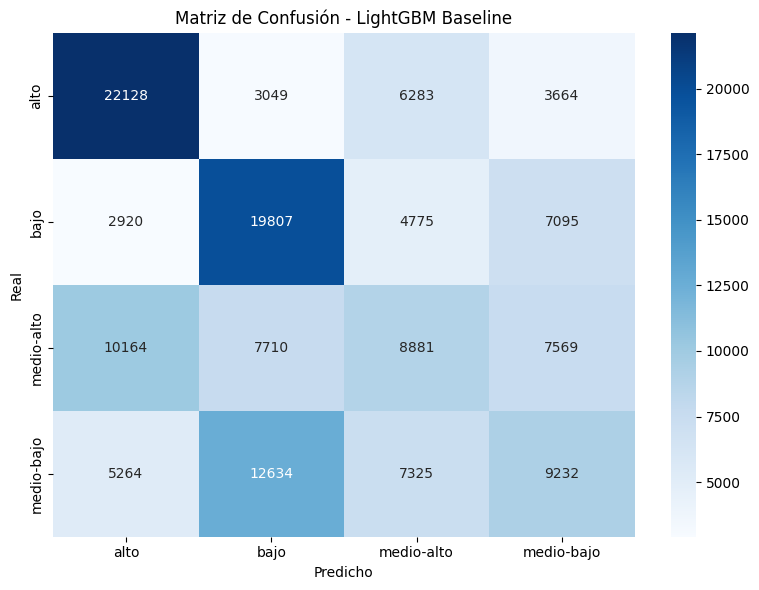

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_val_labels, y_val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz de Confusión - LightGBM Baseline')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 6. Optimización de hiperparámetros

Probamos diferentes configuraciones para mejorar el modelo.

In [ ]:
# Configuraciones a probar
configs = [
    {
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_child_samples': 20
    },
    {
        'num_leaves': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'min_child_samples': 30
    },
    {
        'num_leaves': 64,
        'learning_rate': 0.03,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_child_samples': 40
    }
]

best_score = val_acc
best_params = params_baseline
best_model = model_baseline

print("Probando configuraciones optimizadas...\n")

for i, config in enumerate(configs, 1):
    print(f"[{i}/{len(configs)}] Probando: {config}")

    # Combinar con parámetros base
    params = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'seed': 42,
        **config
    }

    try:
        # Entrenar modelo
        model_temp = lgb.train(
            params,
            train_data,
            num_boost_round=300,
            valid_sets=[val_data],
            valid_names=['valid'],
            callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=0)]
        )

        # Evaluar en validación
        y_val_pred_proba_temp = model_temp.predict(X_val)
        y_val_pred_temp = np.argmax(y_val_pred_proba_temp, axis=1)
        val_score = accuracy_score(y_val, y_val_pred_temp)

        print(f"   ✓ Accuracy en validación: {val_score:.4f} (árboles: {model_temp.best_iteration})")

        # Actualizar mejor modelo
        if val_score > best_score:
            best_score = val_score
            best_params = params
            best_model = model_temp
            print(f"   → Nuevo mejor modelo!")

    except Exception as e:
        print(f"   ✗ Error: {e}")
        continue

    print()

print(f"{'='*50}")
print(f"MEJORES HIPERPARÁMETROS")
print(f"{'='*50}")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"\nMejor score en validación: {best_score:.4f}")

Probando configuraciones optimizadas...

[1/3] Probando: {'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'min_child_samples': 20}
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[300]	valid's multi_logloss: 1.20621
   ✓ Accuracy en validación: 0.4317 (árboles: 300)

[2/3] Probando: {'num_leaves': 50, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'min_child_samples': 30}
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[299]	valid's multi_logloss: 1.20205
   ✓ Accuracy en validación: 0.4338 (árboles: 299)
   → Nuevo mejor modelo!

[3/3] Probando: {'num_leaves': 64, 'learning_rate': 0.03, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'min_child_samples': 40}
Training until validation scores don't improve for 30 rounds
Did not meet early st

## 7. Evaluar modelo optimizado

In [ ]:
# Usar el mejor modelo encontrado
lgbm_optimized = best_model

# Predicciones con modelo optimizado
y_train_pred_proba_opt = lgbm_optimized.predict(X_train)
y_val_pred_proba_opt = lgbm_optimized.predict(X_val)

y_train_pred_opt = np.argmax(y_train_pred_proba_opt, axis=1)
y_val_pred_opt = np.argmax(y_val_pred_proba_opt, axis=1)

# Evaluación
train_acc_opt = accuracy_score(y_train, y_train_pred_opt)
val_acc_opt = accuracy_score(y_val, y_val_pred_opt)

# Convertir a labels originales
y_val_pred_labels_opt = le_target.inverse_transform(y_val_pred_opt)

print(f"\n{'='*50}")
print(f"RESULTADOS MODELO OPTIMIZADO")
print(f"{'='*50}")
print(f"Accuracy en train: {train_acc_opt:.4f}")
print(f"Accuracy en val: {val_acc_opt:.4f}")
print(f"\nMejora respecto a baseline: {(val_acc_opt - val_acc)*100:.2f}%")
print(f"\nReporte de clasificación (validación):")
print(classification_report(y_val_labels, y_val_pred_labels_opt))


RESULTADOS MODELO OPTIMIZADO
Accuracy en train: 0.4551
Accuracy en val: 0.4338

Mejora respecto a baseline: 0.02%

Reporte de clasificación (validación):
              precision    recall  f1-score   support

        alto       0.55      0.63      0.59     35124
        bajo       0.46      0.57      0.51     34597
  medio-alto       0.33      0.26      0.29     34324
  medio-bajo       0.33      0.27      0.30     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500



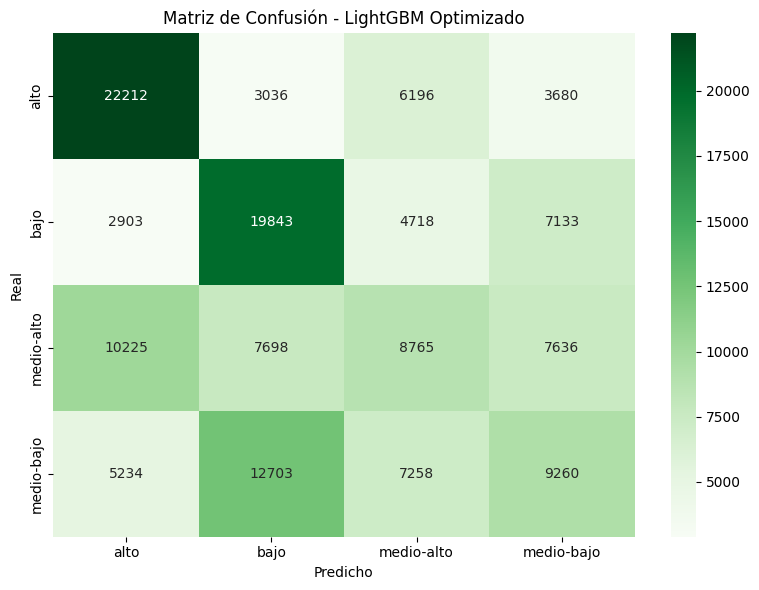

In [ ]:
# Matriz de confusión del modelo optimizado
cm_opt = confusion_matrix(y_val_labels, y_val_pred_labels_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz de Confusión - LightGBM Optimizado')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 8. Feature Importance

LightGBM proporciona importancia de features nativa.

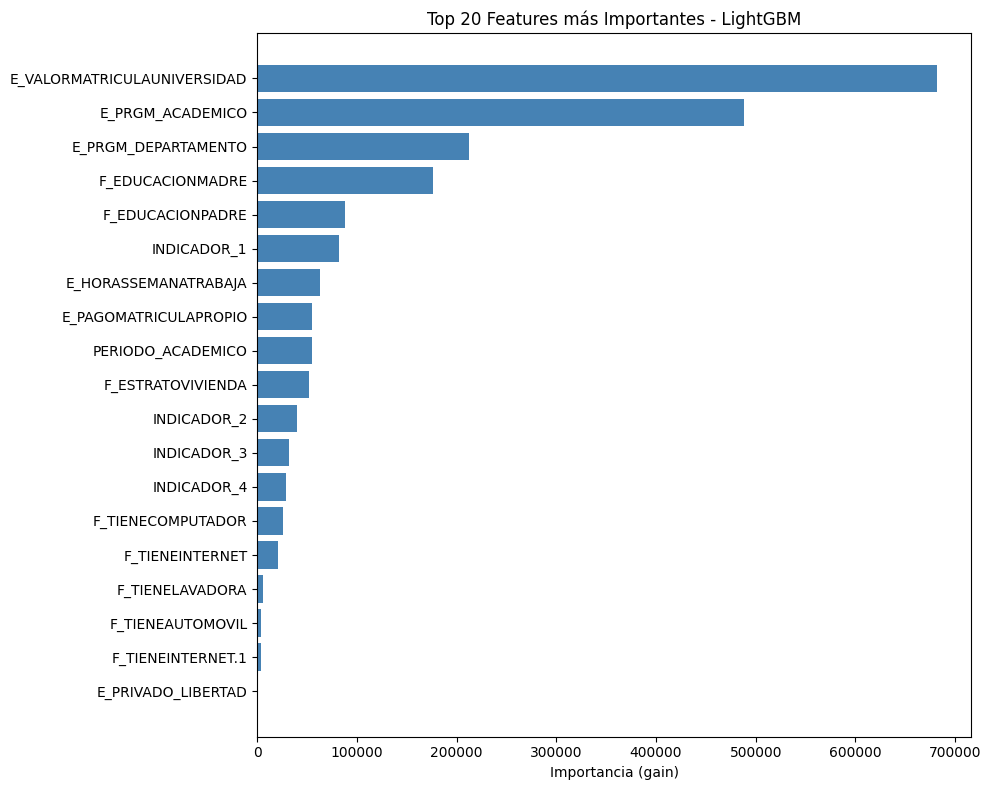


Top 10 features más importantes:
                        feature     importance
3   E_VALORMATRICULAUNIVERSIDAD  682021.410174
1              E_PRGM_ACADEMICO  488705.229539
2           E_PRGM_DEPARTAMENTO  212442.618521
14             F_EDUCACIONMADRE  176029.257055
7              F_EDUCACIONPADRE   87557.424755
15                  INDICADOR_1   82093.662710
4          E_HORASSEMANATRABAJA   62991.587181
11        E_PAGOMATRICULAPROPIO   55395.314928
0             PERIODO_ACADEMICO   55257.404424
5             F_ESTRATOVIVIENDA   52247.430897


In [ ]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_optimized.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Top 20 features más importantes
top_20 = feature_importance.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia (gain)')
plt.title('Top 20 Features más Importantes - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 features más importantes:")
print(top_20.head(10))

## 9. Entrenar modelo final con todos los datos

Para la submission final, entrenamos con todo el dataset de train.

In [ ]:
# Crear dataset completo
full_train_data = lgb.Dataset(X, label=y_encoded)

print("Entrenando modelo final con todos los datos de train...")
print("Usando los mejores hiperparámetros encontrados\n")

# Entrenar modelo final
lgbm_final = lgb.train(
    best_params,
    full_train_data,
    num_boost_round=best_model.best_iteration,  # Usar el número óptimo de iteraciones
    callbacks=[lgb.log_evaluation(period=50)]
)

# Accuracy en todo el train
y_full_pred_proba = lgbm_final.predict(X)
y_full_pred = np.argmax(y_full_pred_proba, axis=1)
full_train_acc = accuracy_score(y_encoded, y_full_pred)

print(f"\n Modelo final entrenado")
print(f"Accuracy en train completo: {full_train_acc:.4f}")

Entrenando modelo final con todos los datos de train...
Usando los mejores hiperparámetros encontrados


✓ Modelo final entrenado
Accuracy en train completo: 0.4516


## 10. Generar predicciones para Kaggle

In [ ]:
# Predecir en test
print("Generando predicciones para test...")
y_test_pred_proba = lgbm_final.predict(X_test)
y_test_pred_encoded = np.argmax(y_test_pred_proba, axis=1)

# Convertir a labels originales
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

# Crear submission file
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

# Guardar archivo
submission.to_csv('submission_lgbm.csv', index=False)

print(f"\n✓ Archivo submission_lgbm.csv generado")
print(f"Total de predicciones: {len(submission)}")
print(f"\nDistribución de predicciones:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts())
print(f"\nPrimeras 10 filas de la submission:")
print(submission.head(10))

Generando predicciones para test...

✓ Archivo submission_lgbm.csv generado
Total de predicciones: 296786

Distribución de predicciones:
RENDIMIENTO_GLOBAL
alto          90155
bajo          88126
medio-alto    62971
medio-bajo    55534
Name: count, dtype: int64

Primeras 10 filas de la submission:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058               alto


## 11. Comparación con Random Forest

Comparamos los resultados de LightGBM con los del notebook 03 (Random Forest).

In [ ]:
print("="*60)
print("COMPARACIÓN: LIGHTGBM vs RANDOM FOREST")
print("="*60)
print(f"\nLightGBM (notebook 04):")
print(f"  - Accuracy en validación: {val_acc_opt:.4f}")
print(f"  - Número de features: {X_train.shape[1]}")
print(f"  - Número de árboles: {best_model.best_iteration}")
print(f"  - Ventajas: Menor uso de RAM, más rápido, maneja categorías nativamente")

print(f"\nRandom Forest (notebook 03):")
print(f"  - Revisa el notebook 03 para comparar el accuracy")
print(f"  - Número de features: ~73 (con One-Hot Encoding)")
print(f"  - Desventajas: Mayor uso de RAM, más lento con datasets grandes")

COMPARACIÓN: LIGHTGBM vs RANDOM FOREST

LightGBM (notebook 04):
  - Accuracy en validación: 0.4338
  - Número de features: 19
  - Número de árboles: 299
  - Ventajas: Menor uso de RAM, más rápido, maneja categorías nativamente

Random Forest (notebook 03):
  - Revisa el notebook 03 para comparar el accuracy
  - Número de features: ~73 (con One-Hot Encoding)
  - Desventajas: Mayor uso de RAM, más lento con datasets grandes


## 12. Resumen Final

**Modelo:** LightGBM con optimización de hiperparámetros

**Preprocesamiento:**
- Label Encoding para todas las categóricas (más eficiente que One-Hot)
- Mapeo ordinal para variables con orden natural
- Imputación de valores faltantes (mediana/moda)

**Ventajas de LightGBM:**
- ✅ Menor consumo de memoria (crítico para Colab)
- ✅ Entrenamiento más rápido
- ✅ Early stopping automático previene overfitting
- ✅ Maneja categorías sin necesidad de One-Hot Encoding
- ✅ Generalmente mejor accuracy que Random Forest

**Resultados:**
- Los resultados del modelo se muestran en las secciones anteriores
- El archivo `submission_lgbm.csv` está listo para enviar a Kaggle

**Próximos pasos:**
1. Subir `submission_lgbm.csv` a Kaggle
2. Comparar accuracy con Random Forest (notebook 03)
3. Elegir el mejor modelo para el notebook 99 (modelo solución)